In [1]:
# ========= 0) Imports y configuración (opcional) =========
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from threadpoolctl import threadpool_limits

In [2]:
# ========= 1) Cargar datos =========
path = "respuestas_forms.csv"   # <-- ajusta si hace falta
df = pd.read_csv(path, encoding="latin1")

# ========= 2) Separar metadatos vs preguntas =========
meta_cols = [c for c in [
    "ID",
    "Nombre",
    "Correo electrónico",
    "Hora de inicio",
    "Hora de finalización",
    "Hora de la última modificación",
    "Comentarios (opcional)"
] if c in df.columns]

q_cols = [c for c in df.columns if c not in meta_cols]

# Convertir a numérico (Forms guarda 1..5)
df_q = df[q_cols].apply(pd.to_numeric, errors="coerce")


In [3]:
# ========= 3) Reorientar el ítem inverso (si existe) =========
# Queremos que valores altos signifiquen "más cómodo improvisando"
inv_candidates = [c for c in df_q.columns if "Ítem inverso" in c or "Item inverso" in c]
inverse_col = inv_candidates[0] if inv_candidates else None

df_q_oriented = df_q.copy()
if inverse_col:
    df_q_oriented[inverse_col] = 6 - df_q_oriented[inverse_col]  # escala 1..5 -> invertimos

In [4]:
# ========= 4) Imputación simple + estandarización =========
# (por si hay algún NaN, rellenamos con la mediana de la columna)
df_q_oriented = df_q_oriented.dropna(axis=1, how="all")
df_q_oriented = df_q_oriented.apply(lambda s: s.fillna(s.median()), axis=0)

X = StandardScaler().fit_transform(df_q_oriented.values)

In [5]:
# ========= 5) Elbow + silhouette para elegir K =========
# Con pocos participantes, tiene sentido probar K pequeños (2..5)
Ks = list(range(2,10))  # 2..5 si n>=6
inertias = []
sil = []

with threadpool_limits(limits=1):
    for k in Ks:
        km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        labels_k = km.fit_predict(X)
        inertias.append(km.inertia_)                 # SSE (inercia)
        sil.append(silhouette_score(X, labels_k))    # silhouette

# Elegimos K por máximo silhouette (regla práctica)
sel_k = Ks[int(np.argmax(sil))]
print("K seleccionado por silhouette:", sel_k)

K seleccionado por silhouette: 8


K=2: inertia=228.71, silhouette=0.2019


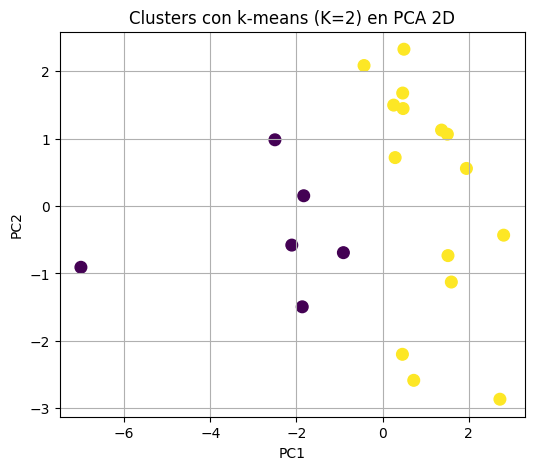

K=3: inertia=191.65, silhouette=0.1211


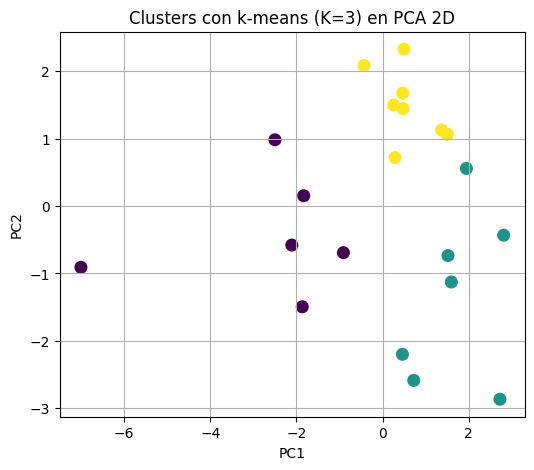

K=4: inertia=165.65, silhouette=0.1279


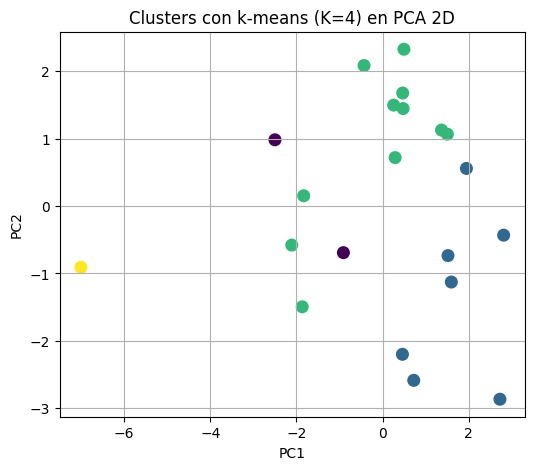

In [9]:
sel_k = 5
for sel_k in range(2,5):
    print(f"K={sel_k}: inertia={inertias[sel_k-2]:.2f}, silhouette={sil[sel_k-2]:.4f}")
    # ========= 6) Entrenar k-means final =========
    with threadpool_limits(limits=1):
        kmeans = KMeans(n_clusters=sel_k, random_state=42, n_init=10, max_iter=300)
        labels = kmeans.fit_predict(X)
    # ========= 7) PCA a 2D =========
    X2 = PCA(n_components=2, random_state=np.random.randint(42)).fit_transform(X)

    # ========= 8) Plots =========
    # (c) PCA scatter con clusters
    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1], c=labels, s=70)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Clusters con k-means (K={sel_k}) en PCA 2D")
    plt.grid(True)
    plt.show()

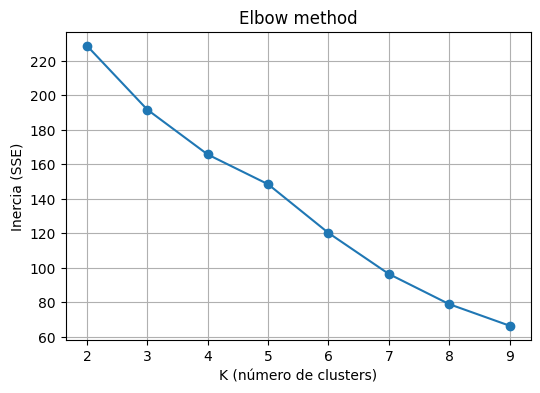

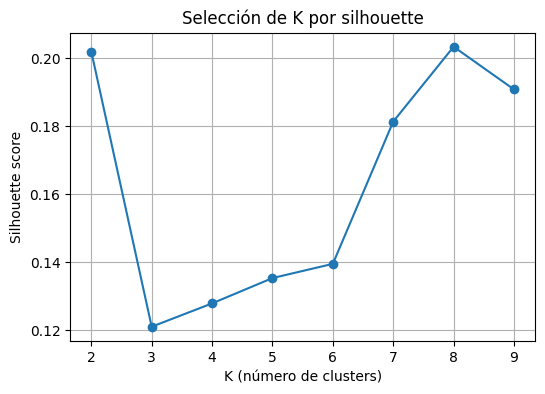

In [7]:
# ========= 8) Plots =========

# (a) Elbow
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker="o")
plt.xlabel("K (número de clusters)")
plt.ylabel("Inercia (SSE)")
plt.title("Elbow method")
plt.grid(True)
plt.show()

# (b) Silhouette
plt.figure(figsize=(6,4))
plt.plot(Ks, sil, marker="o")
plt.xlabel("K (número de clusters)")
plt.ylabel("Silhouette score")
plt.title("Selección de K por silhouette")
plt.grid(True)
plt.show()

In [8]:
# ========= 9) (Opcional) Guardar resultados =========
df_out = df.copy()
df_out["cluster"] = labels
#df_out.to_csv("respuestas_forms_con_clusters.csv", index=False, encoding="utf-8")
print("Guardado: respuestas_forms_con_clusters.csv")


Guardado: respuestas_forms_con_clusters.csv
